## Importing all necessary tools

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download("omw-1.4")

stemmer = PorterStemmer()
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Importing Datasets

In [4]:
from google.colab import drive
import pandas as pd
import os

drive.mount('/content/drive', force_remount=True)

def read_excel_file(file_path):
    try:
        df = pd.read_excel(file_path)
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

def process_excel_files(directory_path, merged=True):

    all_dataframes = []
    file_names = []

    for filename in os.listdir(directory_path):
        if filename.endswith('.xls'):
            filepath = os.path.join(directory_path, filename)
            file_names.append(filename)
            df = read_excel_file(filepath)
            if df is not None:
              all_dataframes.append(df)

    if all_dataframes and merged:
        df = pd.concat(all_dataframes, ignore_index=True)
        print(df.shape)
        return [df], file_names
    elif all_dataframes and not merged:
        return all_dataframes, file_names
    else:
        print("No XLS files found in the specified directory.")

Mounted at /content/drive


## Utility Functions

In [5]:
def vocab_generator(df, col):
    vocab = [word for sublist in df[f"processed_{col}"].to_list() for word in sublist]

    similar_vocab = dict()
    from difflib import get_close_matches

    def find_similar_words(vocab, threshold=0.8):
      unique_vocab = []
      for word in vocab:
        is_similar = False
        for unique_word in unique_vocab:
          if get_close_matches(word, [unique_word], n=1, cutoff=threshold):
            is_similar = True
            similar_vocab[word] = unique_word
            break
        if not is_similar:
          unique_vocab.append(word)
      return set(unique_vocab)

    return find_similar_words(vocab), similar_vocab

In [6]:
def get_full_forms(abbreviation, ml_terms):
    if abbreviation.lower() in ml_terms.keys():
        return ml_terms[abbreviation.lower()]
    return None

ml_terms = {
    "AI": "Artificial Intelligence",
    "ML": "Machine Learning",
    "DL": "Deep Learning",
    "NLP": "Natural Language Processing",
    "CV": "Computer Vision",
    "CNN": "Convolutional Neural Network",
    "RNN": "Recurrent Neural Network",
    "LSTM": "Long Short Term Memory",
    "GRU": "Gated Recurrent Unit",
    "GAN": "Generative Adversarial Network",
    "SVM": "Support Vector Machine",
    "KNN": "KNearest Neighbors",
    "ANN": "Artificial Neural Network",
    "DNN": "Deep Neural Network",
    "PCA": "Principal Component Analysis",
    "t-SNE": "tDistributed Stochastic Neighbor Embedding",
    "ROC": "Receiver Operating Characteristic",
    "AUC": "Area Under the Curve",
    "MSE": "Mean Squared Error",
    "MAE": "Mean Absolute Error",
    "RMSE": "Root Mean Squared Error",
    "ReLU": "Rectified Linear Unit",
    "IoU": "Intersection over Union",
    "TPR": "True Positive Rate",
    "FPR": "False Positive Rate",
    "TP": "True Positive",
    "TN": "True Negative",
    "FP": "False Positive",
    "FN": "False Negative",
    "API": "Application Programming Interface",
    "ETL": "Extract, Transform, Load",
    "EDA": "Exploratory Data Analysis",
    "RL": "Reinforcement Learning",
    "XAI": "Explainable Artificial Intelligence",
    "SHAP": "SHapley Additive exPlanations",
    "LIME": "Local Interpretable Model-agnostic Explanations",
    "BERT": "Bidirectional Encoder Representations from Transformers",
    "GPT": "Generative Pretrained Transformer",
    "LLM": "Large Language Model",
    "LLMs": "Large Language Model",
}

ml_terms = {k.lower(): v.lower() for k, v in ml_terms.items()}

In [7]:
def convert_abbreviation(word):
    if word.isupper() and len(word) > 1:
        full_form = get_full_forms(word, ml_terms)
        if full_form:
            return full_form
        synsets = wordnet.synsets(word)
        if synsets:
            return synsets[0].lemmas()[0].name()
        else:
            return word
    return word

def preprocess_text(text):
    tokens = word_tokenize(text)
    # Convert abbreviations
    tokens = [convert_abbreviation(word) for word in tokens]
    # Convert to lower case
    tokens = [word.lower() for word in tokens]
    # Stem the word
    # tokens = [stemmer.stem(word) for word in tokens]
    # Remove punctuation and numbers and stem
    tokens = [word for word in tokens if word.isalpha()]
    # Lemmatize the word
    tokens = [wnl.lemmatize(word, pos="v") for word in tokens]
    # Remove stopwords
    tokens = [word for word in tokens if (word not in stop_words)]
    return tokens

In [8]:
def process_column(df, col):
    if col in df.columns:
        df[f'processed_{col}'] = df[col].astype(str).apply(preprocess_text)
        # Find unique vocab words
        unique_vocab, similar_vocab = vocab_generator(df, col)

        def vocab_check(text):
          return [similar_vocab[word] if word in similar_vocab.keys() else word for word in text]

        df[f'processed_{col}'] = df[f'processed_{col}'].apply(vocab_check)

        print(df[[col, f'processed_{col}']].head())
    else:
      print(f"No '{col}' column found in the DataFrame.")
    return df

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools

def plot_network(df, col, file_name, top_nodes=None, plot_it=True):
    tokenized_lists = df[f'processed_{col}'].to_list()

    # Build co-occurrence networSk
    G = nx.Graph()

    for list_ in tokenized_lists:
        for item1, item2 in itertools.combinations(list_, 2):
            if top_nodes and (item1 not in top_nodes or item2 not in top_nodes):
                continue
            if G.has_edge(item1, item2):
                G[item1][item2]['weight'] += 1
            else:
                G.add_edge(item1, item2, weight=1)

    if plot_it:
        # Visualization with weighted edges
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(G, k=0.5)

        # Nodes
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color="#f7c5bb")

        # Edges
        edges = G.edges(data=True)
        edge_width = [d['weight']*0.1 for _, _, d in edges]  # Scale edge widths by weight
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_width, edge_color="#b6b7c9")

        # Labels
        nx.draw_networkx_labels(G, pos, font_size=12)

        plt.title(f"'processed_{col}' Co-occurrence Network\nfor file: {file_name}\nTotal nodes: {G.number_of_nodes()}")
        plt.axis('off')
        plt.show()

    edges_data = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]
    edges_df = pd.DataFrame(edges_data, columns=['Source', 'Target', 'Weight'])
    edges_df_sorted = edges_df.sort_values(by='Weight', ascending=False)
    print(edges_df_sorted)
    return G

**Node degree**: *Measures how "connected" a node is*

**Node strength**: *Measures how "important" a node is based on edge weights*

In [10]:
def node_degree(G, print_it=True):
  # Calculate and display the degree of each node in the network
  node_degrees = {node: G.degree(node) for node in G.nodes()}
  node_degrees_sorted = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)

  if print_it:
      # Displaying as a DataFrame
      print(pd.DataFrame(node_degrees_sorted, columns=['Node', 'degree']).set_index('Node'))
  return node_degrees_sorted

In [11]:
def node_strength(G, print_it=True):
  # Calculate node strength (sum of weights of edges connected to the node)
  node_strengths = {node: sum(G[node][neighbor]['weight'] for neighbor in G[node]) for node in G.nodes()}

  # Convert node strengths to a sorted list for display
  node_strengths_sorted = sorted(node_strengths.items(), key=lambda x: x[1], reverse=True)

  if print_it:
      # Displaying as a DataFrame
      print(pd.DataFrame(node_strengths_sorted, columns=['Node', 'Strength']))
  return node_strengths_sorted

In [12]:
def plot_strength_vs_degree(G):
    # Calculate average strength (average weight) for each node
    average_strength = {node: 0 for node in G.nodes()}
    for node in G.nodes():
        total_weight = sum([attr['weight'] for _, _, attr in G.edges(node, data=True)])
        average_strength[node] = total_weight / G.degree(node)

    # Extract degree and average strength for each node
    degrees = [G.degree(node) for node in G.nodes()]
    average_strengths = [average_strength[node] for node in G.nodes()]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(degrees, average_strengths, color='blue')
    plt.title("Average Strength vs. Degree")
    plt.xlabel("Degree")
    plt.ylabel("Average Strength (Weight)")
    plt.grid(True)
    plt.show()

In [13]:
def plot_top_nodes(df, col, file_name, n=50):
    degree = node_degree(G, print_it=False)
    strength = node_strength(G, print_it=False)

    strength_df = pd.DataFrame(strength, columns=['Node', 'Strength']).set_index('Node')
    degree_df = pd.DataFrame(degree, columns=['Node', 'degree']).set_index('Node')
    analysis_df = pd.merge(strength_df, degree_df, left_index=True, right_index=True)
    analysis_df = analysis_df.sort_values(by='Strength', ascending=False)
    analysis_df.reset_index(inplace=True)
    top_nodes = analysis_df.head(n).Node.to_list()
    plot_network(df, col, file_name, top_nodes=top_nodes)

## Compilation & Execution of Utility Functions
1. Load the files
2. Preprocess the column (Author Keywords)
3. Generating the Co-occurence Network
4. Computing Node Degree
5. Computing Node Strength
6. Plotting Node Degree vs Average Node Strength
7. Finding and Plotting Top 50 Nodes

This execution runs for each year.

Processing file:  2020.xls

Pre-processing the column
                                     Author Keywords  \
0  Human-AI Interaction; Generative Deep Neural N...   
1  Generative modelling; artificial intelligence;...   
2  Artificial intelligence; Generative art; Live ...   
3  AI (artificial intelligence); Amyloid imaging;...   
4  conditional generative adversarial networks; p...   

                           processed_Author Keywords  
0   [interaction, generative, deep, neural, network]  
1  [generative, model, artificial, intelligence, ...  
2  [artificial, intelligence, generative, art, li...  
3  [artificial, intelligence, amyloid, image, cad...  
4  [conditional, generative, adversarial, network...  

Plotting the network
           Source         Target  Weight
62     generative        network     191
1060      network    adversarial     167
78     generative    adversarial     158
85     generative          learn      97
1069      network          learn      75
...        

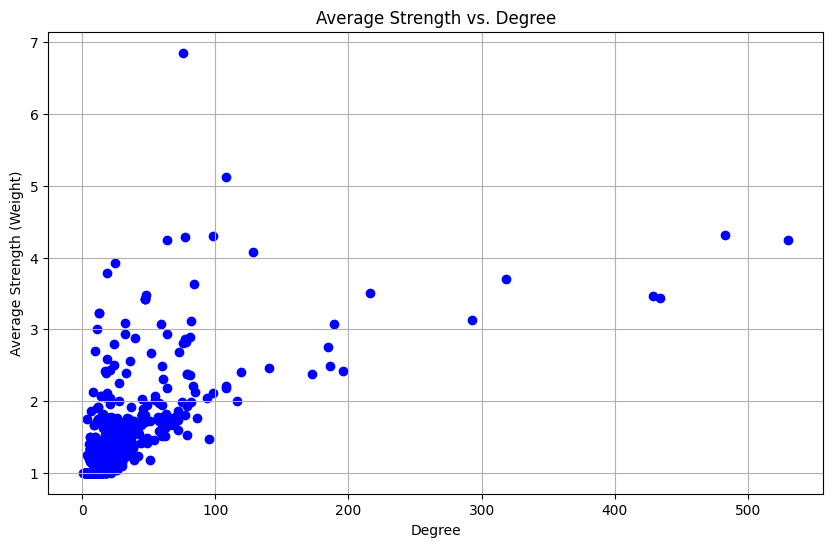


Plotting the top nodes


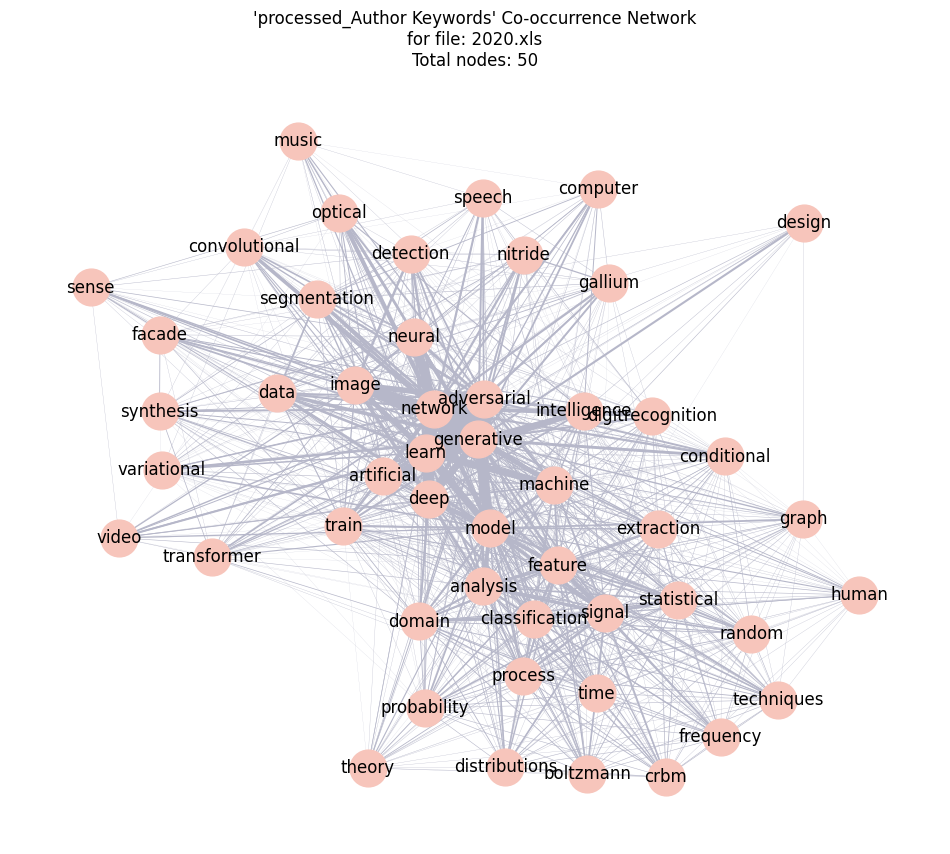

         Source       Target  Weight
2    generative      network     191
138     network  adversarial     167
11   generative  adversarial     158
12   generative        learn      97
141     network        learn      75
..          ...          ...     ...
894        crbm         crbm       1
893  techniques   techniques       1
887   frequency    frequency       1
883        time       facade       1
882        time         time       1

[899 rows x 3 columns]
Processing file:  2021.xls

Pre-processing the column
                                     Author Keywords  \
0  Generative modelling; artificial intelligence;...   
1  machine learning; human-AI co-creation; music ...   
2  neural machine translation; NMT; generative AI...   
3  Generative Machine Learning; AI Education; Gen...   
4  generative art; style transfer; biases; AI; so...   

                           processed_Author Keywords  
0  [generative, model, artificial, intelligence, ...  
1               [machine, learn

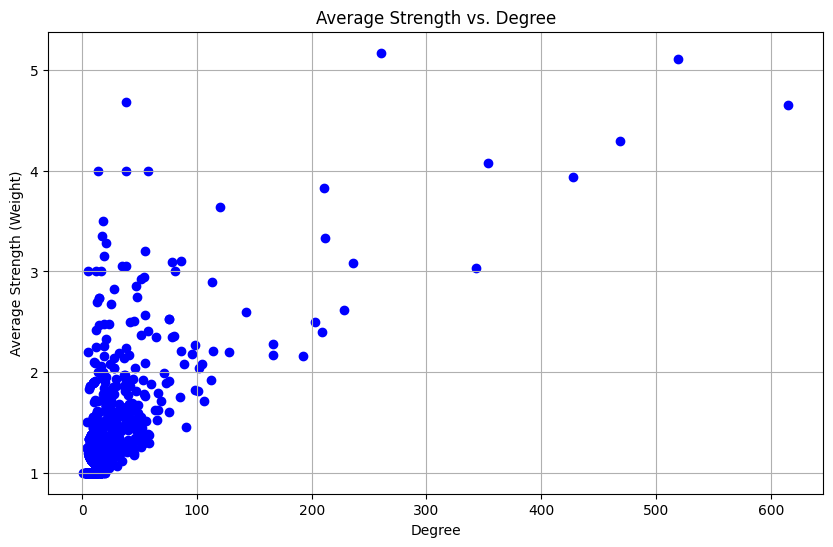


Plotting the top nodes


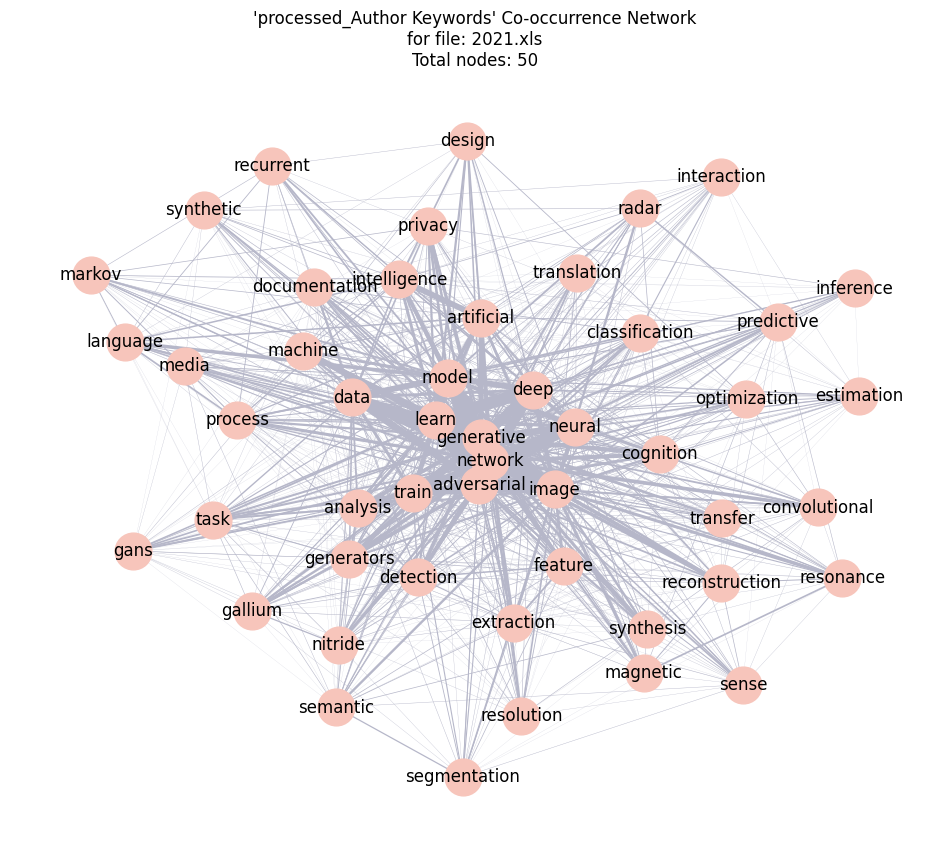

            Source         Target  Weight
10      generative        network     238
322    adversarial        network     201
9       generative    adversarial     200
8       generative          learn     120
0       generative          model     108
..             ...            ...     ...
795      synthesis        nitride       1
794      synthesis        gallium       1
842  convolutional           task       1
816          train        process       1
838        process  convolutional       1

[855 rows x 3 columns]
Processing file:  2022.xls

Pre-processing the column
                                     Author Keywords  \
0           Generative AI; Design; Bias; Uncertainty   
1  generative AI; software engineering tooling; e...   
2  visual programming environment; generative con...   
3  Generative modelling; artificial intelligence;...   
4  Generative Design; Digital Manufacturing; Topo...   

                           processed_Author Keywords  
0            [generative, 

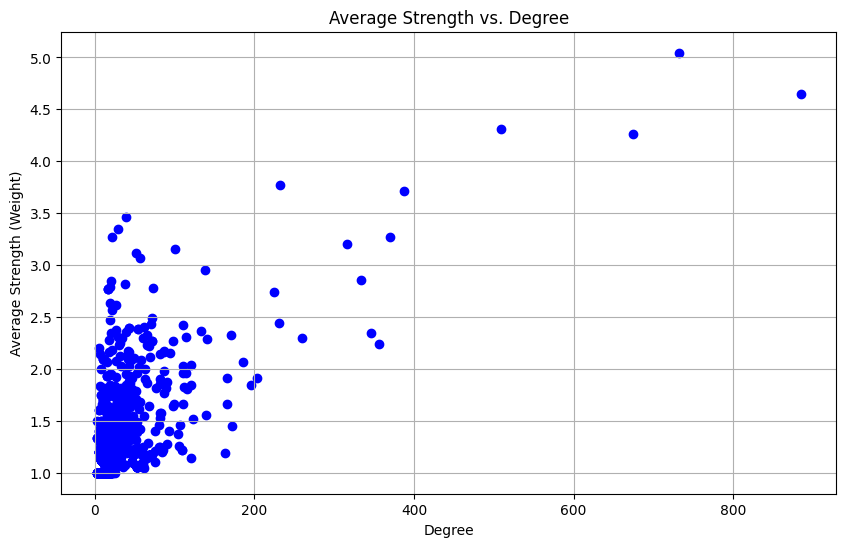


Plotting the top nodes


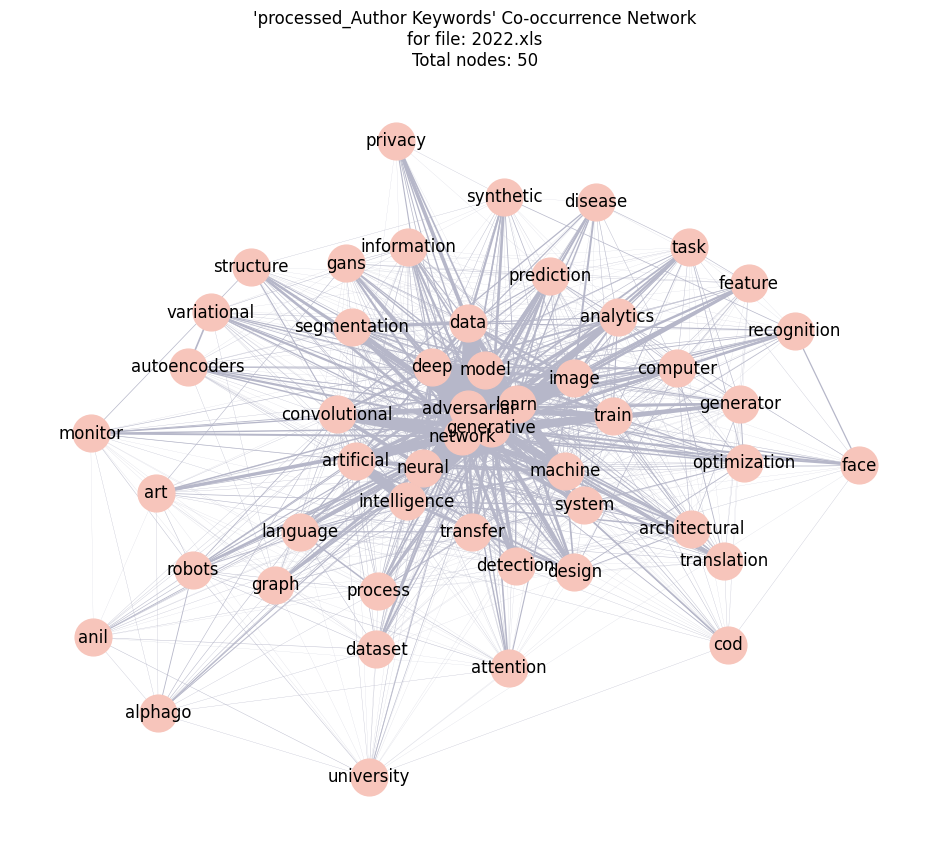

          Source        Target  Weight
10    generative       network     342
266  adversarial       network     304
8     generative   adversarial     297
14    generative         learn     173
348      network         learn     140
..           ...           ...     ...
781        graph  segmentation       1
789    synthetic     attention       1
788    synthetic       disease       1
337       neural  autoencoders       1
779     transfer       disease       1

[839 rows x 3 columns]
Processing file:  2023.xls

Pre-processing the column
                                     Author Keywords  \
0       HCI; AI; Generative AI; Human-AI Interaction   
1  Generative AI; learning; education; personas; ...   
2  Legal; Law; Explainable AI; Blockchain; Genera...   
3  AI governance; AI regulation; generative AI; g...   
4  Speculative Design; Generative AI; Creativity;...   

                           processed_Author Keywords  
0                     [hci, generative, interaction]  
1  [gen

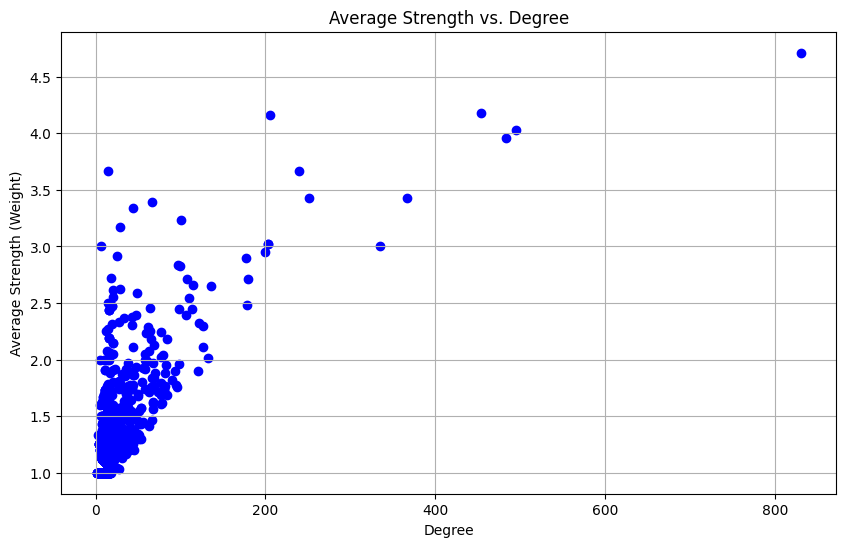


Plotting the top nodes


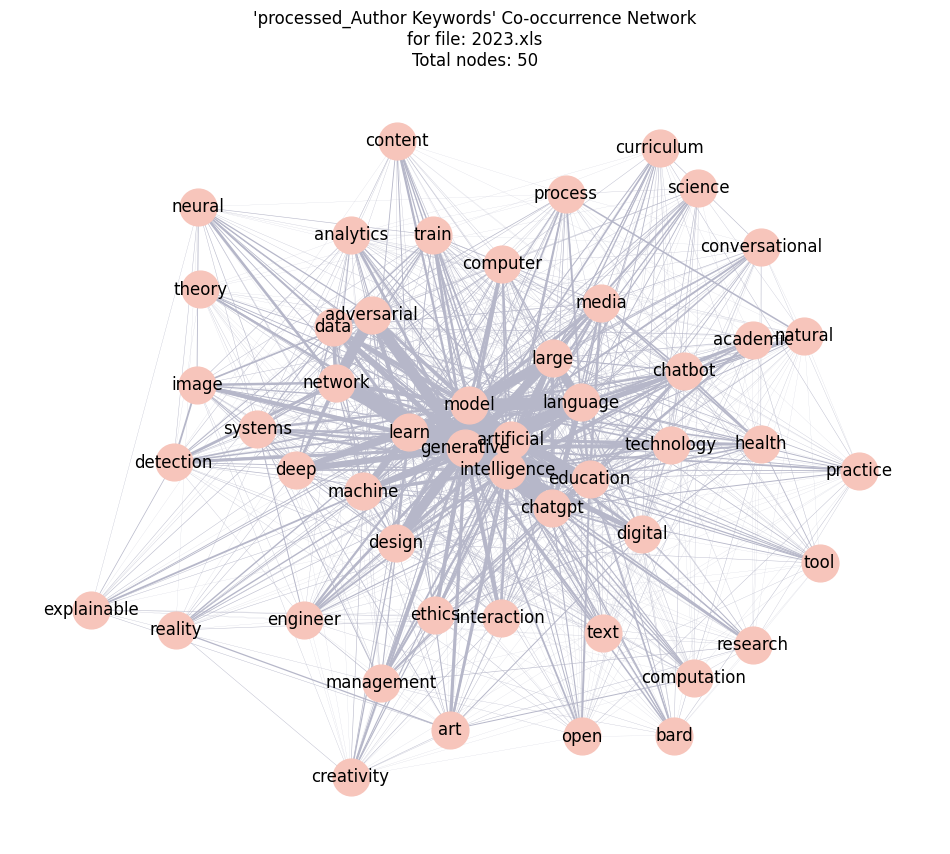

           Source        Target  Weight
643  intelligence    artificial     206
6      generative         model     200
22     generative  intelligence     162
26     generative    artificial     158
1      generative         learn     127
..            ...           ...     ...
862      computer        neural       1
863      computer           art       1
880        health           art       1
892   computation    curriculum       1
893    curriculum    curriculum       1

[894 rows x 3 columns]
Processing file:  2024.xls

Pre-processing the column
                                     Author Keywords  \
0  Generative AI; design principles; human-center...   
1  Large Language Model; ChatGLM; Generative AI; ...   
2  Artificial Intelligence; AI; AI literacy; Algo...   
3  Diffusion Models; Generative Adversarial Netwo...   
4                     Generative AI; Economic Agents   

                           processed_Author Keywords  
0  [generative, design, principles, foundation, m.

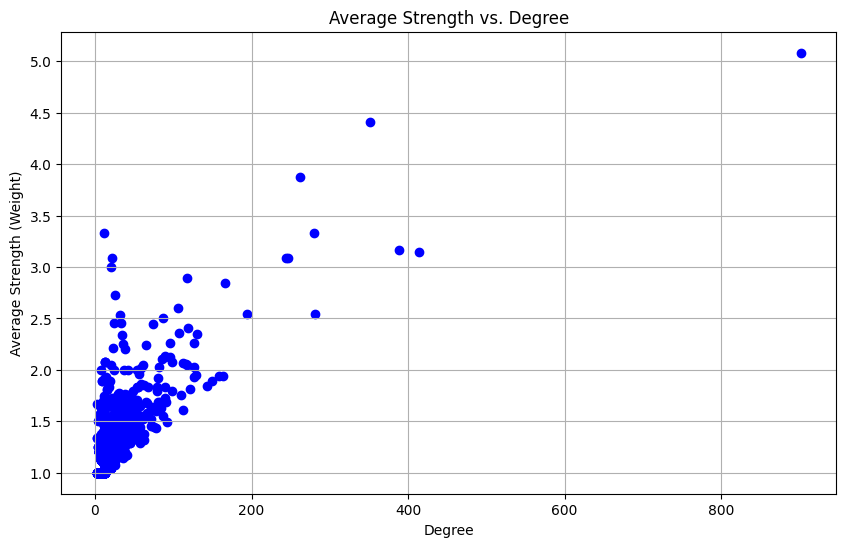


Plotting the top nodes


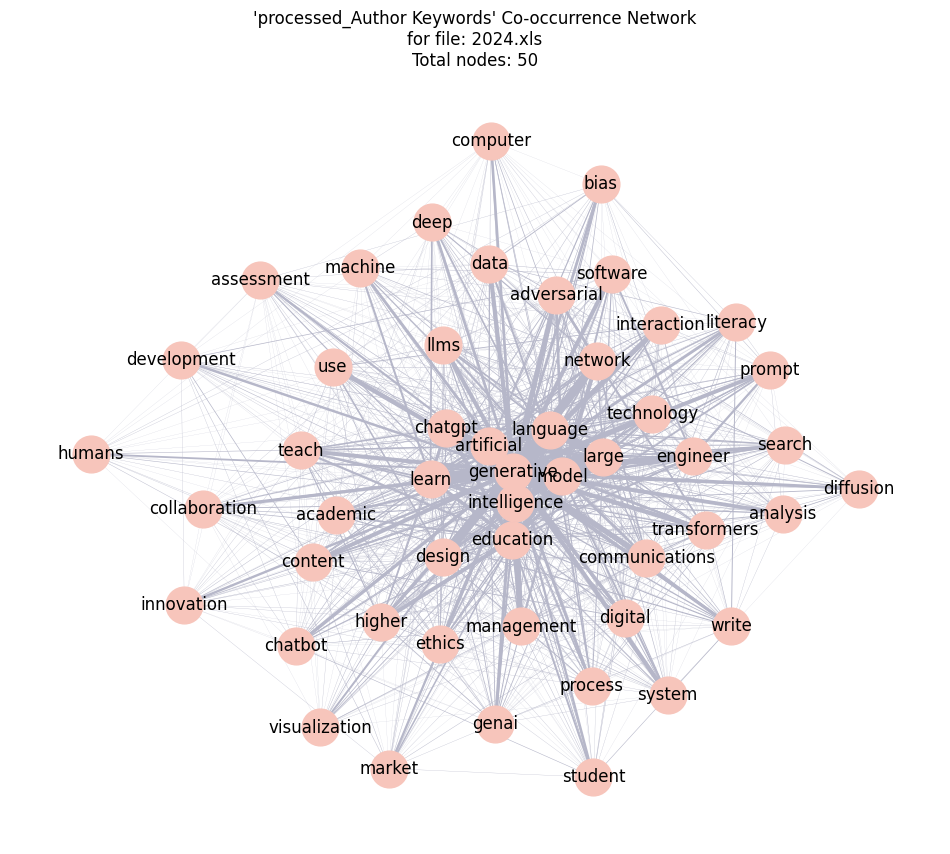

         Source        Target  Weight
1    generative         model     188
5    generative  intelligence     151
4    generative    artificial     143
224  artificial  intelligence     125
15   generative     education     121
..          ...           ...     ...
51       design          bias       1
237  artificial    innovation       1
324    literacy           use       1
852      humans       chatgpt       1
851      humans    assessment       1

[904 rows x 3 columns]


In [14]:
directory_path = '/content/drive/MyDrive/IE6400/Project3/data'

dfs, file_names = process_excel_files(directory_path, merged=False)

for i, df in enumerate(dfs):
  if len(dfs) > 1:
    print("Processing file: ", file_names[i])
  else:
    print("Processing merged data")

  col = 'Author Keywords'
  print()
  print("Pre-processing the column")
  print("="*50)
  df = process_column(df, col)

  print()
  print("Plotting the network")
  print("="*50)
  G = plot_network(df, col, file_names[i], plot_it=False)

  print()
  print("Calculating the node degree")
  print("="*50)
  degree = node_degree(G)

  print()
  print("Calculating the node strength")
  print("="*50)
  strength = node_strength(G)

  print()
  print("Plotting the strength vs degree")
  print("="*50)
  plot_strength_vs_degree(G)

  print()
  print("Plotting the top nodes")
  print("="*50)
  plot_top_nodes(df, col, file_names[i], n=50)


# Observations

## 2020
We can observe a new trends in design especially in facade, which is mostly used for architectural designs. We also observe models used were transformer and graph type models. Also, there are new trends in music and speech classification.

## 2021
We observe the introduction of new nodes such as radar, magnetic, resonance and segmentation. This indicates the heavy research being done on self driving cars and this could also be indicating the models being developed for coronavirus detection.

## 2022
There is a strong node for "disease" which explains the research being conducted on coronavirus and other related diseases. We also observe new nodes such as face and recognition which could be due to masks regulation and social distancing, and enhancements in facial recognition in phones.

## 2023
We can observe that there was in increase in the usage of chatbots and introduction of AI tools like chatgpt. We also see other nodes such as content, academic and interaction, as there is an increase in content creation and chatbot like services in different fields.

## 2024
We observe that there is an introduction of "prompt" node which is an indicator of an increase in the number of research papers of prompt engineering indirectly indicating further development in the space of AI.